In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split 
import statsmodels.api as sm

# Begin exploration

In [333]:
all_data = pd.read_csv('data/manchester_data.csv').set_index('geo_code_lsoa')

In [313]:
all_data.head()

,local_auth,age_mean,age_median,badhealth,centheat,nodepr,depr_3+,studenthhold,nocars,eth_hhi,ethwhite,nodepr_med,nocars_med,median_age_quar
geo_code_lsoa,,,,,,,,,,,,,,
E01005268,Manchester,40.40783,36.0,0.054014,0.976861,0.509054,0.026157,0.001006,0.280684,0.285152,0.884539,above_med,above_med,Q2
E01033656,Manchester,22.29914,21.0,0.004585,0.909330,0.371879,0.003942,0.268068,0.674113,0.361815,0.593410,below_med,above_med,Q1
E01005184,Manchester,29.31636,22.0,0.038190,0.966624,0.441592,0.048780,0.219512,0.410783,0.159142,0.672324,above_med,above_med,Q1
E01005298,Manchester,30.76403,30.0,0.052861,0.973479,0.483619,0.060842,0.015601,0.260530,0.064515,0.407629,above_med,below_med,Q1
E01005300,Manchester,36.61435,34.0,0.065343,0.977551,0.404082,0.057143,0.004082,0.159184,0.060058,0.357463,above_med,below_med,Q2


In [334]:
tokeep = ['median_age_med', 'badhealth', 'centheat', 'studenthhold', 'ethwhite', 'nodepr', 'nocars']

man_data = all_data[tokeep]

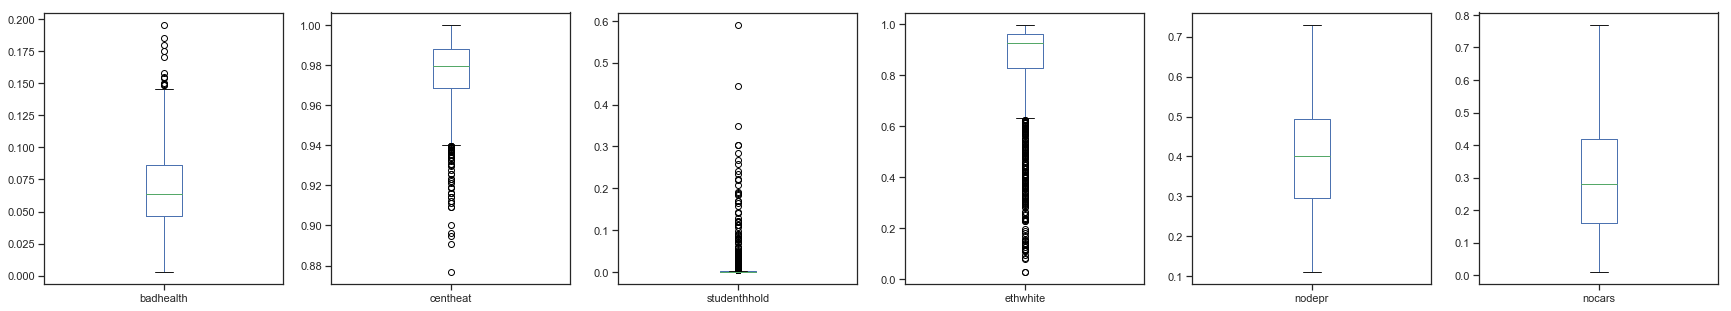

In [316]:
# box plots
man_data.plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

In [91]:
'''# Show histogram of each feature
man_data.hist(figsize=(15, 15))
plt.show()

# this should show all of them??'''

'# Show histogram of each feature\nman_data.hist(figsize=(15, 15))\nplt.show()\n\n# this should show all of them??'

In [145]:
'''
#Display a scatter matrix
pd.plotting.scatter_matrix(man_data.drop('nodepr_cat', axis = 1), diagonal = 'hist',  figsize=(15, 15))
plt.show()
'''

"\n#Display a scatter matrix\npd.plotting.scatter_matrix(man_data.drop('nodepr_cat', axis = 1), diagonal = 'hist',  figsize=(15, 15))\nplt.show()\n"

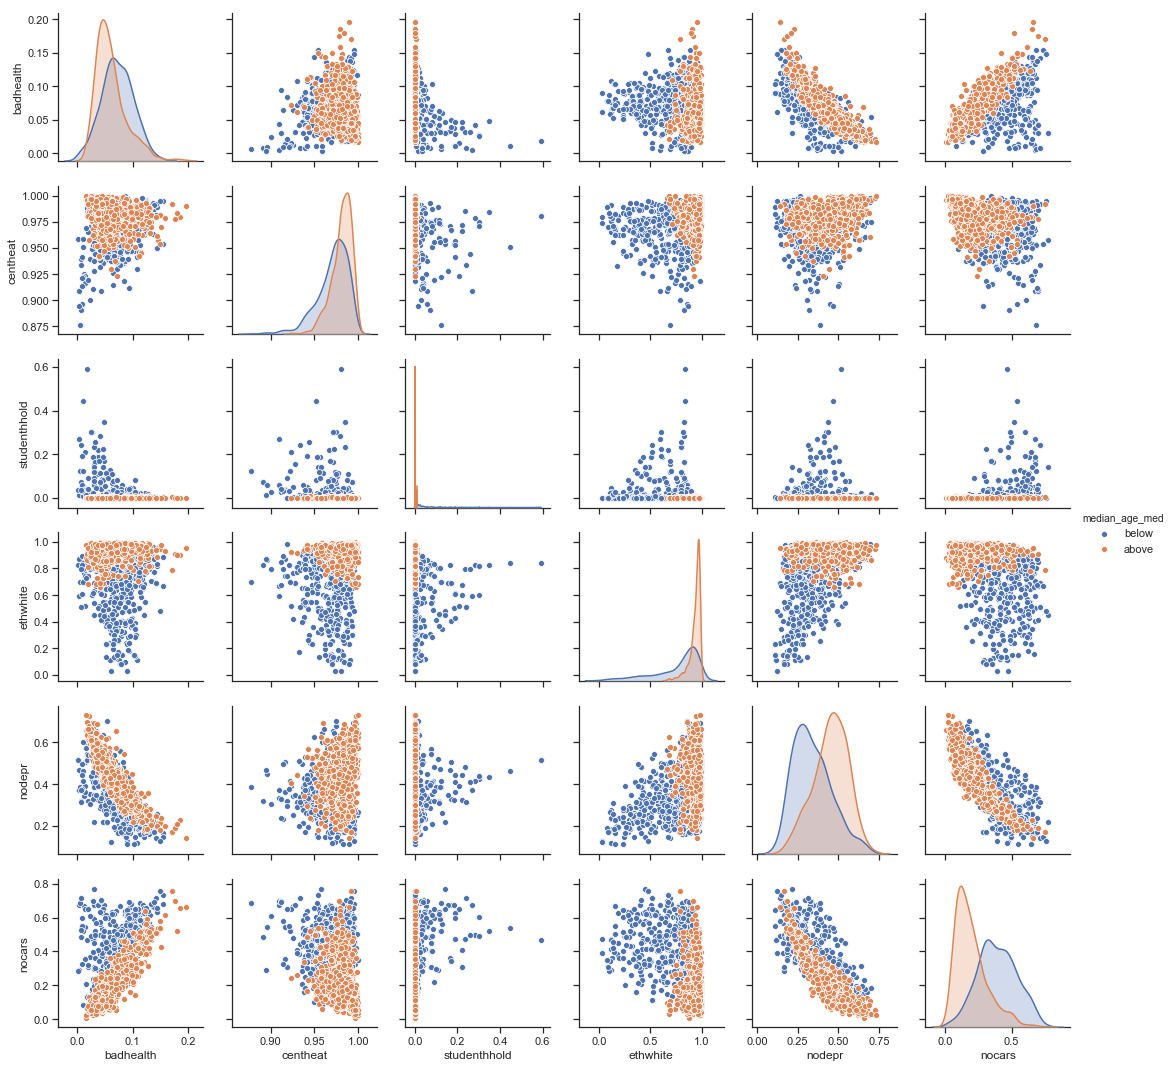

In [335]:
sns.set(style="ticks")
sns.pairplot(man_data, hue = 'median_age_med')

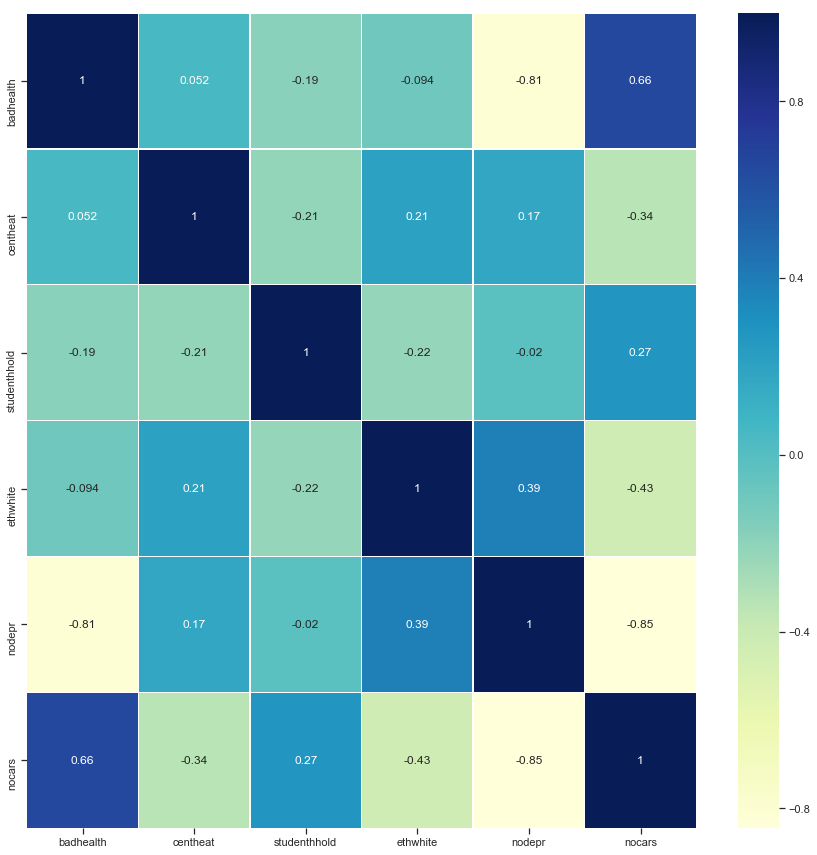

In [336]:
axsns = plt.subplots(figsize=(15, 15))
sns.heatmap(man_data.corr(), annot=True, linewidths=.5, cmap="YlGnBu")
plt.show()

# K-means

In [283]:
# use the elbow method
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(results)
    wcss.append(kmeans.inertia_)

In [284]:
"""
    K-Means parameters 
    n_clusters = the number of clusters
    init = the method for placing initial centroids
    max_iter = the maximum amount of iterations
    n_init = the number of times that K-means is run with different random centroids
    random_state = the seed value
"""
# use the elbow method
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(results)
    wcss.append(kmeans.inertia_)

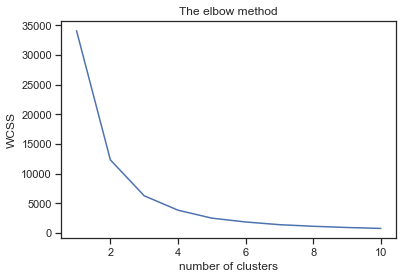

In [285]:
# Plot the WCSS results
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

In [286]:
# Apply K-means to petal data based on WCSS results
kmeans = KMeans(n_clusters=2, init = 'k-means++', max_iter=300, n_init=10, random_state=0)

# this will create an arry for the predicted clusters for the petal data
y_kmeans = kmeans.fit_predict(results)

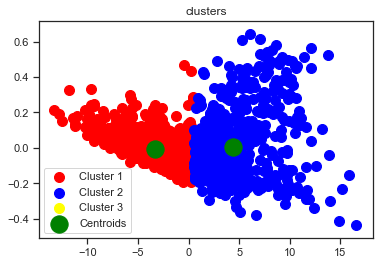

In [287]:
# Visualise the clusters
# Specify that we want the observation in X where the cluster == 0

"""
    X               = The dataset 
    [y_kmeans==0    = Where the cluster == 0 - uses the index of y-kmeans to selected rows from x
    , 0]            = The first column in the dataset
    s = 100         = The size of the points
    c = 'red'       = The color of the cluster
"""
plt.scatter(results[y_kmeans==0, 0], results[y_kmeans==0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(results[y_kmeans==1, 0], results[y_kmeans==1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(results[y_kmeans==2, 0], results[y_kmeans==2, 1], s=100, c='yellow', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='green', label='Centroids')
plt.title('clusters')
plt.legend()
plt.show()

# PCA

In [337]:
# Convert data to array
data = man_data.iloc[:,1:].values

In [338]:
# Perform PCA
pca = PCA(n_components=None) # Create an instance of the PCA class
"""
    We dont specify the amount of components to reduce to yet 
    as we want to see how many Princible Components explain the most varience in 
    the dataset
"""
pcaResults = pca.fit_transform(data) # Fit the data to the model
explained_variance = pca.explained_variance_ratio_ # Extract the varience

In [339]:
print(np.around(explained_variance,3) )

[0.674 0.265 0.045 0.011 0.003 0.002]


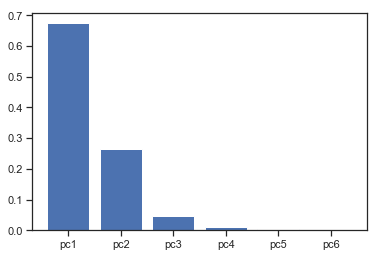

In [340]:
# Plot the explained varience
pcaComponents = ['pc1','pc2','pc3','pc4','pc5','pc6']
y_pos = np.arange(len(pcaComponents))
plt.bar(y_pos, explained_variance)
plt.xticks(y_pos, pcaComponents)
plt.show()

In [341]:
# Convert data to array
# Perform PCA
pca = PCA(n_components=2) # Now specify 2 components
results = pca.fit_transform(data)

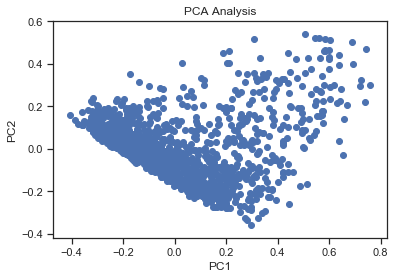

In [342]:
# Show Plot
plt.scatter(results[:,0], results[:,1])
plt.title('PCA Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [329]:
colour_map = {
    'Q1': 'red',
    'Q2' : 'blue',
    'Q3' : 'green',
    'Q4' : 'purple'
}

In [343]:
colour_map = {
    'above': 'blue',
    'below' : 'orange',
}

In [66]:
'''
# Define Color map
colour_map = {
    'Manchester': 'red',
    'Tameside' : 'blue',
    'Stockport' : 'green',
    'Trafford' : 'yellow',
    'Bury' : 'orange',
    'Rochdale' : 'purple',
    'Wigan' : 'grey',
    'Salford' : 'black',
    'Oldham' : 'brown'
}
'''

In [54]:
'''
# Define Color map
colour_map = {
    0 : 'red',
    1 : 'blue'
}
'''

In [344]:
# Create an array of colours based on the target column
colours = [colour_map[c] for c in man_data['median_age_med']]

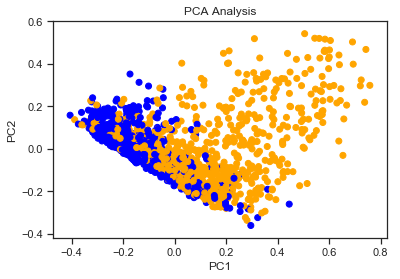

In [345]:
# Show Plot
plt.scatter(results[:,0], results[:,1], c=colours)
plt.title('PCA Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Regression

In [346]:
tokeep = ['nocars', 'badhealth', 'centheat', 'studenthhold', 'ethwhite', 'nodepr', 'median_age_med']

man_data = all_data[tokeep]

In [347]:
#Reference Variable
man_data['_intercept'] = 1 # if all variables == 0

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [351]:
# Create Dummy Variables
dummy_df = pd.get_dummies(man_data.median_age_med, prefix='median_age_med')
man_data = man_data.join(dummy_df)
man_data = man_data.drop(['median_age_med', 'median_age_med_below'], axis=1)

# View Results
man_data.head()

,nocars,badhealth,centheat,studenthhold,ethwhite,nodepr,_intercept,median_age_med_above
geo_code_lsoa,,,,,,,,
E01005268,0.280684,0.054014,0.976861,0.001006,0.884539,0.509054,1,0
E01033656,0.674113,0.004585,0.909330,0.268068,0.593410,0.371879,1,0
E01005184,0.410783,0.038190,0.966624,0.219512,0.672324,0.441592,1,0
E01005298,0.260530,0.052861,0.973479,0.015601,0.407629,0.483619,1,0
E01005300,0.159184,0.065343,0.977551,0.004082,0.357463,0.404082,1,0


In [352]:
# import the dataset
x = man_data.iloc[:, :-1] # predictors
y = man_data.iloc[:,-1] # result 

# split the dataset into the training set and test set
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state=5)

In [353]:
# Make the model
logit = sm.Logit(y_train, x_train)

# Fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 13


C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [354]:
# View the results
print (result.summary())

                            Logit Regression Results                            
Dep. Variable:     median_age_med_above   No. Observations:                 1196
Model:                            Logit   Df Residuals:                     1189
Method:                             MLE   Df Model:                            6
Date:                  Tue, 26 Feb 2019   Pseudo R-squ.:                     inf
Time:                          17:07:33   Log-Likelihood:                   -inf
converged:                         True   LL-Null:                        0.0000
                                          LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
nocars         -20.6130      1.871    -11.017      0.000     -24.280     -16.946
badhealth       81.1780      8.237      9.855      0.000      65.034      97.322
centheat        16.4678     

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [355]:
# Get the predicted values from the test set
y_pred = result.predict(x_test)

In [356]:
# print confusion matrix
from sklearn.metrics import *
print(confusion_matrix(y_test, np.round(y_pred,0)))

[[130  19]
 [ 21 130]]


In [357]:
# Accuracy %
from sklearn.metrics import *
accuracy_score(y_test, np.round(y_pred,0))

0.8666666666666667

In [309]:
result.predict([
    48    # age
    ,0   # badhealth
    ,0.8   # centheat 
    ,0.1   # studenthhold
    ,0.9   # ethwhite
    ,0.4   # nodepr
    ,1   # Intercept
])

array([0.98858362])